In [ ]:
#!pip install tensorflow==2.15

import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:

# Milestone Project 2: ScimLit

# The purpose of this notebook is to build an NLP model to make reading medical absctracts easier
# The paper we are replicating (the source of datasets we will be using ) https://arxiv.org/abs/1710.06071

# And reading through the paper above, we see that the model architecture that they use to achieve their best results is
# available here : https://arxiv.org/abs/1612.05251

# lots of diagram is in the github https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


In [ ]:
# datasets here https://github.com/Franck-Dernoncourt/pubmed-rct

import tensorflow as tf
tf.__version__

'2.9.0'

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 33.09 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# !ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k datasets with numbers replaced by the @



In [ ]:

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
## Preprocess data

def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# [{'line_number': 0,
# 'target': 'BACKGROUND',
# 'text':'Emotional eating is associated with overeating and the development of obesity .\n' ,
# 'total_lines': 11}, ...]
import re

def preprocess_line_with_regex(line):
    match = re.match(r"(\w+)\s+(.*)", line)  # Dopasuj: pierwsze słowo, a potem resztę
    if match:
        return [match.group(1), match.group(2)]
    return [line.strip(), ""]




def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        if len(target_text_split) != 2:
          target_text_split = preprocess_line_with_regex(abstract_line)
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")



len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
test_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ %

In [ ]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

test_df.tail(14)

,target,text,line_number,total_lines
30121,BACKGROUND,there is a need to investigate varying exercis...,4,17
30122,METHODS,twenty-eight individuals from outpatient physi...,5,17
30123,METHODS,"apart from repetition volume , all other aspec...",6,17
30124,METHODS,tendinopathy clinical severity was assessed wi...,7,17
30125,METHODS,pain intensity was assessed using a visual ana...,8,17
30126,METHODS,"both were assessed at baseline , @ weeks , and...",9,17
30127,METHODS,treatment satisfaction was assessed at week @ .,10,17
30128,METHODS,adverse effects were also monitored .,11,17
30129,RESULTS,there was a statistically significant within-g...,12,17
30130,RESULTS,there was a statistically significant between-...,13,17


In [ ]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


In [ ]:
test_df.target.value_counts()

,count
target,
METHODS,9897
RESULTS,9713
CONCLUSIONS,4571
BACKGROUND,3621
OBJECTIVE,2333


<Axes: ylabel='Frequency'>

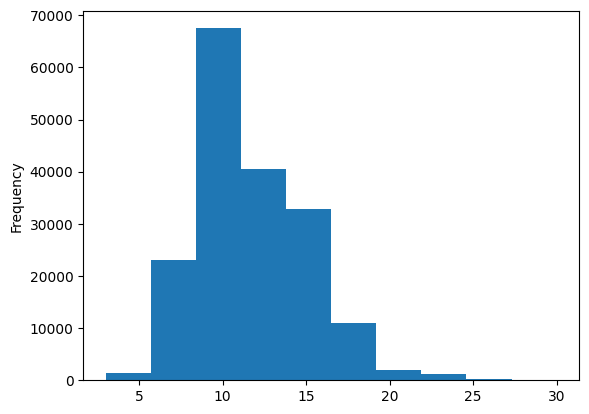

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
###

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# Make numeric labels

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf


one_hot_encoder = OneHotEncoder(sparse_output=False)

import sklearn
print(sklearn.__version__)

1.6.0


In [ ]:

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
train_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [ ]:
train_df["target"].to_numpy().reshape(-1,1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

In [ ]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:

val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
# Extract labels (target columns )
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())


train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and numbers of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
### base line model
# Model 0 :

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline



model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # Instantiate the TfidfVectorizer
    ("clf", MultinomialNB())
])

# Fit the model to your training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate


model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model


baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-04-20 13:51:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-20 13:51:02 (84.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:


baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds

)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# Model 1
## Conv 1D with token embeddings

import numpy as np
import tensorflow as tf
from tensorflow.keras  import layers

In [ ]:
# How long is each sentence on average ?
# Make predictions using our baseline model

# Evaluate

### base line model
# Model 0 :

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Extract labels (target columns )
from sklearn.preprocessing import LabelEncoder

train_df.total_lines.plot.hist()
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())


train_labels_encoded

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # Instantiate the TfidfVectorizer
    ("clf", MultinomialNB())
])

# Fit the model to your training data
model_0.fit(X=train_sentences, y=train_labels_encoded)
model_0.score(X=val_sentences,
                 y=val_labels_encoded)
baseline_preds = model_0.predict(val_sentences)

baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds

)

baseline_results
sent_lens = [len(sentence.split()) for sentence in train_sentences]

avg_sent_len = np.mean(sent_lens)
avg_sent_len

chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

26.338269273494777

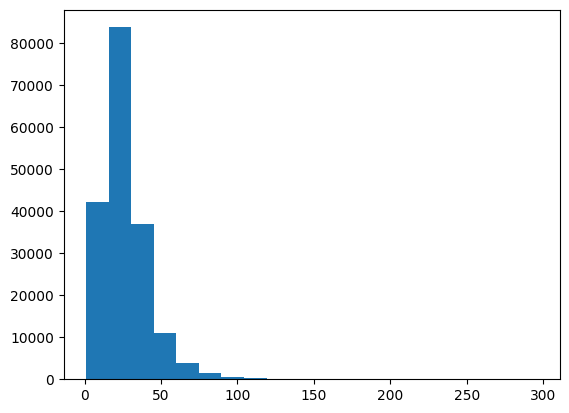

In [ ]:
# What's the distribution look like ?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum lenght

max(sent_lens)

296

In [ ]:
### Create text vectorizer layer

# How many words are in our vocab ? (taken from table 2) https://arxiv.org/pdf/1710.06071.pdf

max_tokens = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization



text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random


target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
hearing threshold in conventional audiometric frequencies was measured and standard threshold shift was calculated for each ear .

Length of text: 18

Vectorized text: [[ 2414  1123     5   366 19139  2656    10   156     3   165  1123  3348
     10   757    11   122  3223     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary


rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab 64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
### Create custom text embedding


# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of param of train
                               mask_zero=True, # use masking to handle variable sequence len()
                               name="token_embedding"
                               )

In [ ]:
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentene shape: {embedded_sentence.shape}")

Sentence before vectorization:
 hearing threshold in conventional audiometric frequencies was measured and standard threshold shift was calculated for each ear .
Sentence after vectorization (before embedding):
 [[ 2414  1123     5   366 19139  2656    10   156     3   165  1123  3348
     10   757    11   122  3223     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[-0.03237307  0.02565018 -0.04836868 ... -0.002599   -0.0380013
   -0.02473222]
  [ 0.00319508  0.04553442 -0.01272526 ...  0.0406909  -0.03816671
    0.02146013]
  [ 0.02555252 -0.00209771 -0.02134837 ...  0.01438046 -0.01136967
    0.02118908]
  ...
  [ 0.00668931 -0.04597062 -0.00535276 ...  0.00923579 -0.04414247
    0.03842219]
  [ 0.00668931 -0.04597062 -0.00535276 ...  0.00923579 -0.04414247
    0.0384221

In [ ]:
## Creating datasets (making sure our data loads as fast as possible)

# https://www.tensorflow.org/guide/data_performance
# https://www.tensorflow.org/guide/data

# Turn our data into TensorFlow Datesets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets

# https://colab.research.google.com/drive/1noqf_VEu_g0VTiJLb391yAdLGXy7R15j?authuser=1#scrollTo=UYOjGNQc_kbS

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
## Model 1: Conv1D with token embeddings

inputs = layers.Input(shape=(1,), dtype=tf.string) # one sequwnce at the time
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # 1 - dimesional sequences , condance the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only 10 % of batches

Epoch 1/3
562/562 [==============================] - 61s 108ms/step - loss: 0.9221 - accuracy: 0.6342 - val_loss: 0.6828 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 68s 122ms/step - loss: 0.6558 - accuracy: 0.7575 - val_loss: 0.6300 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 85s 151ms/step - loss: 0.6164 - accuracy: 0.7735 - val_loss: 0.5981 - val_accuracy: 0.7822


In [ ]:
len(train_dataset)

5627

In [ ]:
562 / 32

17.5625

In [ ]:
5627 * 32 # samples

180064

In [ ]:
# Evaluate on whole validation dateset

model_1.evaluate(valid_dataset)


945/945 [==============================] - 7s 7ms/step - loss: 0.5999 - accuracy: 0.7861


[0.5998612642288208, 0.7860783934593201]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(array([[4.32142556e-01, 1.71886221e-01, 7.67313913e-02, 2.85994411e-01,
         3.32454704e-02],
        [4.94675457e-01, 2.13118076e-01, 1.55324480e-02, 2.70057976e-01,
         6.61593536e-03],
        [1.30650371e-01, 7.28196558e-03, 1.00711209e-03, 8.61043036e-01,
         1.74938323e-05],
        ...,
        [5.06537162e-06, 4.75118752e-04, 4.86704404e-04, 3.74998967e-06,
         9.99029398e-01],
        [5.84695190e-02, 4.57947940e-01, 1.12824865e-01, 6.46935403e-02,
         3.06064069e-01],
        [1.38866544e-01, 7.16073036e-01, 3.35519873e-02, 3.78546007e-02,
         7.36538321e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results



{'accuracy': 78.60783794518734,
 'precision': 0.7832513575779139,
 'recall': 0.7860783794518734,
 'f1': 0.7835383385487394}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
## Model 2: Feature extraction with pretrained token embeddings

# Now lets use pretrained word embeddings from Tensorflow Hub ,
# more specifu=ically the universal sentence encoder:

# https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
# The paper originally used GloVe embeddings, however , we are going
# to stick with the later created USE pretrained embeddings

# Download pretrained Tensorflow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}\n")






Random sentence:
 there was little or no association between patient 's perception of time to onset of effect and change in fev@ , or change in percent predicted fev@ .
Sentence after embedding:
 [ 0.04289254 -0.03042547 -0.08713496 -0.01692146 -0.07916109  0.06729838
  0.04806066 -0.03265832  0.03960377  0.06388887  0.05745989  0.05887251
  0.08042478  0.07840941  0.06023828 -0.03276446 -0.08442055 -0.08420962
 -0.00633039 -0.03399144  0.09084461  0.06068366 -0.00506021  0.0604432
 -0.03486846  0.04110066  0.05122816  0.00871544 -0.02582011 -0.00605283]

Length of sentence embedding: 512



In [ ]:
## Model 2: BUilding and fitting an NLP feature extraction model using pretrained embeddings

inputs = layers.Input(shape=[], dtype=tf.string) # one sequwnce at the time
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text automatically and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model

history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only 10 % of batches

Epoch 1/3
562/562 [==============================] - 18s 18ms/step - loss: 0.9170 - accuracy: 0.6466 - val_loss: 0.7984 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7697 - accuracy: 0.7016 - val_loss: 0.7563 - val_accuracy: 0.6995
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.7532 - accuracy: 0.7120 - val_loss: 0.7383 - val_accuracy: 0.7158


In [ ]:
# Evaluate on whole validation dateset

model_2.evaluate(valid_dataset)



945/945 [==============================] - 18s 19ms/step - loss: 0.7406 - accuracy: 0.7134


[0.7405967712402344, 0.7133920192718506]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 21s 22ms/step


In [ ]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

In [ ]:
baseline_results

In [ ]:
model_1_results

In [ ]:
## Model 3: Conv1D with character embeddings
# Creating a character-level tokenizer
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))


# Text splitting non-character-level sequence into characters

split_chars(random_train_sentence)

In [ ]:

# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

In [ ]:
# What's the average char length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

In [ ]:
# Check the distribution

import matplotlib.pyplot as plt

plt.hist(chars_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len


In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
#random.choice(train_sentences)
len(alphabet)

68

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV out of vocab '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    #standardize="lower_and_strip_punctuation",
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt

char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")


In [ ]:
# Creating a character level embedding


char_embed = layers.Embedding(input_dim=len(char_vocab), # size of the vocabulary ,
                              output_dim=25,  # each character gets embedded of the 25 size feature vector )
                              mask_zero=True,
                              name="char_embed")


In [ ]:
# test

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"CHaracter embedding shape: {char_embed_example.shape}")

In [ ]:
len(random_train_chars)

In [ ]:
## BUildding a Conv1D to fit on character embedding




inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddinngs = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddinngs)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [ ]:
model_3.summary()

In [ ]:
## Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit a model on chars only

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

In [ ]:


model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

In [ ]:
# Model 4: model 2(Pretrained token embeddings) + model 3(character embeddings )
#1. Create a token-level model (similar to model_1)
#2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
#3. Combine (using layers.Concatenate) the outputs of 1 and 2
#4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
#5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                           char_model.output])


# 4. Create output layers - adding in Dropout, discussed in in section 4.2

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

In [ ]:
# PLot hybrid token andcharacter model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
### Combining token and character data into dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))


# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
### Combining token and character data into dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset, val_char_token_dataset

In [ ]:

history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

In [ ]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)


In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
#
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

model_4_results

In [ ]:
# Model 5: Transfer learning with Pretrained token embeddings + character embeddings + positional embeddings

train_df.head()

In [ ]:
# Engineering features need to be available at test time
# Line numbers and total times are availble


### Create positional embedings
# distribution total lines

train_df["line_number"].value_counts()


In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# Use tf to create one hot encoded tensor

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

In [ ]:
train_df["total_lines"].value_counts()

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of total lines value of 20

np.percentile(train_df.total_lines, 98)

In [ ]:
# Use TF to create one hot encoded tenssor of our total lines features

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

In [ ]:
### Building a tribrid embedding model


# 1.  Create a token-level model (similar to model_1)
# 2.  Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
# 3.  Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
# 4.  Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
# 5.  Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
# 6.  Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
# 7.  Create an output layer to accept the tribrid embedding and output predicted label probabilities
# 8.  Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model



In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                             outputs=char_bi_lstm)


# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)


# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
# dense layer 32 units & relu activation
y = layers.Dense(32, activation="relu")(total_lines_inputs)
# combine inputs & dense layer into model
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. combine 3 4 5

tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])


# 7. Create output layer

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input], outputs=output_layer)




In [ ]:
model_5.summary()

In [ ]:
# Plot model_5 to explore it visually ...

from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevend overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# For example, instead of having an output prediction of:
# [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
# It's predictions will get smoothed to be something like:
# [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.


In [ ]:
# Create tribrid embddings datesets using tf.data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# Do the same to val

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


#


In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                              )

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 87s 88ms/step


array([[0.49026555, 0.11955948, 0.01002868, 0.36354765, 0.01659858],
       [0.5651607 , 0.10233215, 0.0409644 , 0.2809489 , 0.01059392],
       [0.26592404, 0.10965911, 0.13438548, 0.4047798 , 0.08525157],
       ...,
       [0.0364807 , 0.09023614, 0.03722662, 0.02997245, 0.80608416],
       [0.03475925, 0.31438398, 0.08360841, 0.02619703, 0.54105127],
       [0.18703358, 0.6076042 , 0.08814108, 0.04228023, 0.07494086]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results

{'accuracy': 83.26823778631007,
 'precision': 0.8321556785562826,
 'recall': 0.8326823778631007,
 'f1': 0.8315428097231506}

In [ ]:
model_4_results

{'accuracy': 73.40460744075202,
 'precision': 0.7346859359890894,
 'recall': 0.7340460744075202,
 'f1': 0.7311732538794827}

In [ ]:
## Compare model results

# Combine model reults into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transponse()
all_model_results


In [ ]:

abstract_lines = "asd fff ggg ggg"
x = abstract_lines.splitlines()
x

['asd fff ggg ggg']

In [ ]:
abstract_line = "32243\tvvgv"
abstract_line.split("\t")

['32243', 'vvgv']

In [ ]:
x = 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'
x.isspace()
y = 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'

False

In [ ]:
z = x + y

In [ ]:
c = z.splitlines()
c[0]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'

# Mój kod

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
train_data = data_dir + '/' + 'train.txt'
test_data = data_dir + '/' + 'test.txt'
val_data = data_dir + '/' + 'dev.txt'


In [ ]:
def read_lines(filename):
  with open(filename) as f:
    return f.readlines()

In [ ]:
read_lines(train_data)[:6]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n']

In [ ]:


def preprocess_text_with_line_numbers(filename):
  all = []
  for line in read_lines(filename):
    D = {}
    if line.startswith('###'):
      lines = ""
    elif line.isspace():
      split_list = lines.splitlines()
      # print(split_list)
      for i, x in enumerate(split_list):
        D = {}
        #print(split_list)
        split_line = x.split('\t')
        if len(split_line) != 2:
          pass
        D['target'] = split_line[0]
        D['text'] = split_line[1]
        D['line_number'] = i
        D['total_lines'] = len(split_list) - 1
        all.append(D)
    else:
      lines += line
  return all

In [ ]:
train_split = preprocess_text_with_line_numbers(train_data)
val_split = preprocess_text_with_line_numbers(val_data)
test_split =  preprocess_text_with_line_numbers(test_data)

In [ ]:
import pandas as pd
train_sentences = pd.DataFrame(train_split)
val_sentences = pd.DataFrame(val_split)
test_sentences = pd.DataFrame(test_split)

In [ ]:
train_sentences

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
...,...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"For PAV , a significantly greater percentage o...",8,11
180037,RESULTS,Both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,11


In [ ]:
train_to_list = train_sentences['text'].to_list()
val_to_list = val_sentences['text'].to_list()

In [ ]:
import random
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

<Axes: ylabel='Frequency'>

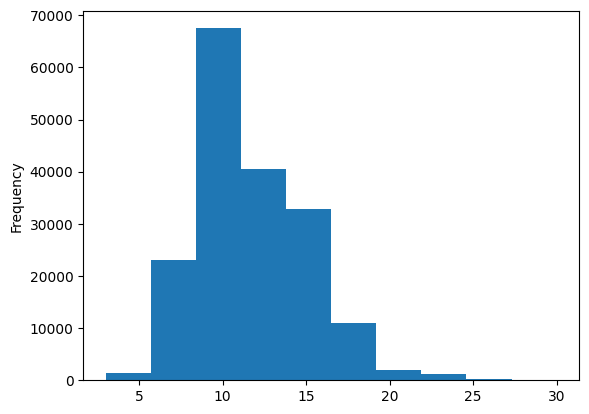

In [ ]:
max_tokens = 68000
train_sentences.total_lines.plot.hist()

In [ ]:

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_sentences["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_sentences["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_sentences["target"].to_numpy().reshape(-1, 1))

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_sentences["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_sentences["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_sentences["target"].to_numpy())

In [ ]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_to_list, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_to_list, y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_to_list)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds

)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_to_list]

In [ ]:
import numpy as np
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_to_list)

In [ ]:
target_sentence = random.choice(train_to_list)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Text:
In stage @ , mean NPI Agitation/Aggression scores were reduced from @ to @ with dextromethorphan-quinidine and from @ to @ with placebo .

Length of text: 24

Vectorized text: [[    5   531    57  7831 27545   119     9   191    27     6     7 14108
      3    27     6     7    48     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Number of words in vocab 64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding"
                               )

In [ ]:
num_classes = len(train_sentences['target'].unique())

In [ ]:
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same')(x)
print(x.shape)
x = tf.keras.layers.GlobalAveragePooling1D(name='AveragePooling')(x)
print(x.shape)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

(None, 55, 64)
(None, 64)


In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_to_list, train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_to_list, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

model_1.fit(
    train_dataset,
    validation_data=(val_dataset),
    validation_steps=int(0.1 * len(val_dataset)),
    steps_per_epoch = int(0.1 * len(train_dataset)),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 69s 121ms/step - loss: 0.9007 - accuracy: 0.6384 - val_loss: 0.6709 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 75s 133ms/step - loss: 0.6509 - accuracy: 0.7593 - val_loss: 0.6270 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.6195 - accuracy: 0.7726 - val_loss: 0.5973 - val_accuracy: 0.7763


In [ ]:
model_1_preds = model_1.predict(val_dataset)


945/945 [==============================] - 5s 5ms/step


In [ ]:
model_1_preds.shape

(30212, 5)

In [ ]:
model_1_preds = tf.argmax(model_1_preds, axis=1)

In [ ]:
model_1_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_1_preds

)
model_1_results

{'accuracy': 78.21726466304779,
 'precision': 0.7795857387071777,
 'recall': 0.7821726466304779,
 'f1': 0.7793697548346843}

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    input_shape=[],
    dtype=tf.string
)

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
model_2 = tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_to_list, train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_to_list, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_2.fit(
    train_dataset,
    validation_data=(val_dataset),
    validation_steps=int(0.1 * len(val_dataset)),
    steps_per_epoch = int(0.1 * len(train_dataset)),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9152 - accuracy: 0.6509 - val_loss: 0.7972 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7670 - accuracy: 0.7028 - val_loss: 0.7528 - val_accuracy: 0.7081
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7499 - accuracy: 0.7153 - val_loss: 0.7356 - val_accuracy: 0.7141


In [ ]:
model_2_pred = model_2.predict(val_dataset)
model_2_pred = tf.argmax(model_2_pred, axis=1)

945/945 [==============================] - 11s 11ms/step


In [ ]:
model_2_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_pred
)
model_2_results

{'accuracy': 71.60068846815835,
 'precision': 0.7163748053048646,
 'recall': 0.7160068846815835,
 'f1': 0.713166512449823}

In [ ]:
def char_split(words):
  return " ".join(list(words))

In [ ]:
train_char = [char_split(x) for x in train_to_list]
val_char = [char_split(x) for x in val_to_list]

In [ ]:
sen = 'ffhfh hfhfh hfhhf'
m = char_split(sen)
len(m)

33

290

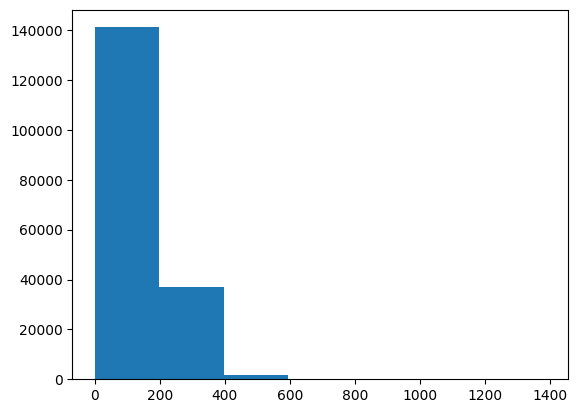

In [ ]:
import matplotlib.pyplot  as plt
char_lens = [len(x) for x in train_to_list]
char_lens

plt.hist(char_lens, bins=7)

output_char_seq_len = int(np.percentile(char_lens, 95))
output_char_seq_len

In [ ]:
import string
NUM_CHAR_TOKENS = string.ascii_lowercase + string.punctuation + string.digits
NUM_CHAR_TOKENS = len(NUM_CHAR_TOKENS)
NUM_CHAR_TOKENS, output_seq_len

(68, 55)

In [ ]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS+2,
                                    output_sequence_length=output_char_seq_len)


In [ ]:
char_vectorizer.adapt(train_char)

In [ ]:
len(char_vectorizer.get_vocabulary())

28

In [ ]:
char_embed = Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                               output_dim=25,
                               mask_zero=True,
                               name="char_embedding"
                               )

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x) # GlobalAveragePooling1D
print(x.shape)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

(None, 64)


In [ ]:


model_3.fit(
    train_char_dataset,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset)),
    steps_per_epoch = int(0.1 * len(train_char_dataset)),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 13s 22ms/step - loss: 1.2504 - accuracy: 0.5032 - val_loss: 1.0174 - val_accuracy: 0.6047
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.9744 - accuracy: 0.6178 - val_loss: 0.9204 - val_accuracy: 0.6393
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.8990 - accuracy: 0.6502 - val_loss: 0.8473 - val_accuracy: 0.6759


In [ ]:
model_3_preds = model_3.predict(val_char_dataset)
model_3_preds

945/945 [==============================] - 6s 7ms/step


array([[0.23498087, 0.39607298, 0.08945088, 0.23199144, 0.04750379],
       [0.17863102, 0.5203062 , 0.01273681, 0.2459561 , 0.04236986],
       [0.12137049, 0.36095113, 0.12828003, 0.3306069 , 0.05879137],
       ...,
       [0.04122652, 0.06767929, 0.12819834, 0.06566498, 0.6972309 ],
       [0.03409933, 0.11732916, 0.32362184, 0.06146588, 0.46348378],
       [0.3626403 , 0.48427948, 0.05979278, 0.07581075, 0.01747667]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_preds, axis=1)

In [ ]:
model_3_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 67.15212498345029,
 'precision': 0.6666918276272572,
 'recall': 0.6715212498345029,
 'f1': 0.663945885102173}

In [ ]:
# Model 4:
# Sentence Encoder
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_output)
# char layer model
char_inputs = tf.keras.layers.Input((1, ), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

token_char_concat = tf.keras.layers.Concatenate(name='Concatenation_layer')([token_model.output, char_model.output])

combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer)



In [ ]:
model_4.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['token_inputs[0][0]']  

In [ ]:
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_token_char_dataset = tf.data.Dataset.from_tensor_slices((train_to_list, train_char))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_dataset, train_token_char_labels))
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_token_char_dataset = tf.data.Dataset.from_tensor_slices((val_to_list, val_char))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_dataset, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(
    train_token_char_dataset,
    validation_data=val_token_char_dataset,
    validation_steps=int(0.1 * len(val_token_char_dataset)),
    steps_per_epoch = int(0.1 * len(train_token_char_dataset)),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 227s 385ms/step - loss: 0.9865 - accuracy: 0.6059 - val_loss: 0.7815 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 196s 348ms/step - loss: 0.8016 - accuracy: 0.6942 - val_loss: 0.7216 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 192s 342ms/step - loss: 0.7712 - accuracy: 0.7086 - val_loss: 0.6891 - val_accuracy: 0.7390


In [ ]:
model_4_preds = model_4.predict(val_token_char_dataset)

945/945 [==============================] - 80s 80ms/step


In [ ]:

model_4_preds = tf.argmax(model_4_preds, axis=1)

In [ ]:

model_4_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)

In [ ]:
model_4_results

{'accuracy': 73.60320402489077,
 'precision': 0.7355205235232989,
 'recall': 0.7360320402489077,
 'f1': 0.7337220571670714}

In [ ]:
# Model 5:

train_sentences['line_number'].max(), train_sentences['total_lines'].max()

(30, 30)

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_sentences['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_sentences['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_sentences['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_sentences['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype='string')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)
# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype='string')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)
# 3. Line numbers model
line_number_inputs = tf.keras.layers.Input((15, ), dtype=tf.float32)
x = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)
# 4. Total Lines model
total_lines_inputs = tf.keras.layers.Input((20, ), dtype=tf.float32)
y = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)
# Combined
combined_embeddings = tf.keras.layers.Concatenate()([token_model.output, char_model.output])
z = tf.keras.layers.Dense(256, activation='relu')(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)
tribrid_embedding = tf.keras.layers.Concatenate()([line_number_model.output, total_lines_model.output, z])
output_layer = tf.keras.layers.Dense(5, activation='softmax')(tribrid_embedding)


model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input], outputs=output_layer)


model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_to_list,
    train_char
))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_to_list,
    val_char
))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5.fit(
    train_char_token_pos_dataset,
    validation_data=val_char_token_pos_dataset,
    validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
    steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 193s 324ms/step - loss: 0.7555 - accuracy: 0.7186 - val_loss: 0.5447 - val_accuracy: 0.7955
Epoch 2/3
562/562 [==============================] - 176s 314ms/step - loss: 0.5018 - accuracy: 0.8118 - val_loss: 0.4610 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 180s 320ms/step - loss: 0.4643 - accuracy: 0.8200 - val_loss: 0.4451 - val_accuracy: 0.8311


In [ ]:
model_5_preds = model_5.predict(val_char_token_pos_dataset)


945/945 [==============================] - 66s 66ms/step


In [ ]:
model_5_preds = tf.argmax(model_5_preds, axis=1)


In [ ]:
model_5_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_5_preds
)

In [ ]:
model_5_results

{'accuracy': 82.77174632596319,
 'precision': 0.8284267145397602,
 'recall': 0.8277174632596319,
 'f1': 0.8277055426689098}

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

In [ ]:
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.217265,0.779586,0.782173,0.779370
model_2_pretrained_token_embedding,71.600688,0.716375,0.716007,0.713167
model_3_custom_char_embedding,67.152125,0.666692,0.671521,0.663946
model_4_hybrid_char_token_embedding,73.603204,0.735521,0.736032,0.733722
model_5_pos_char_token_embedding,82.771746,0.828427,0.827717,0.827706


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100.0

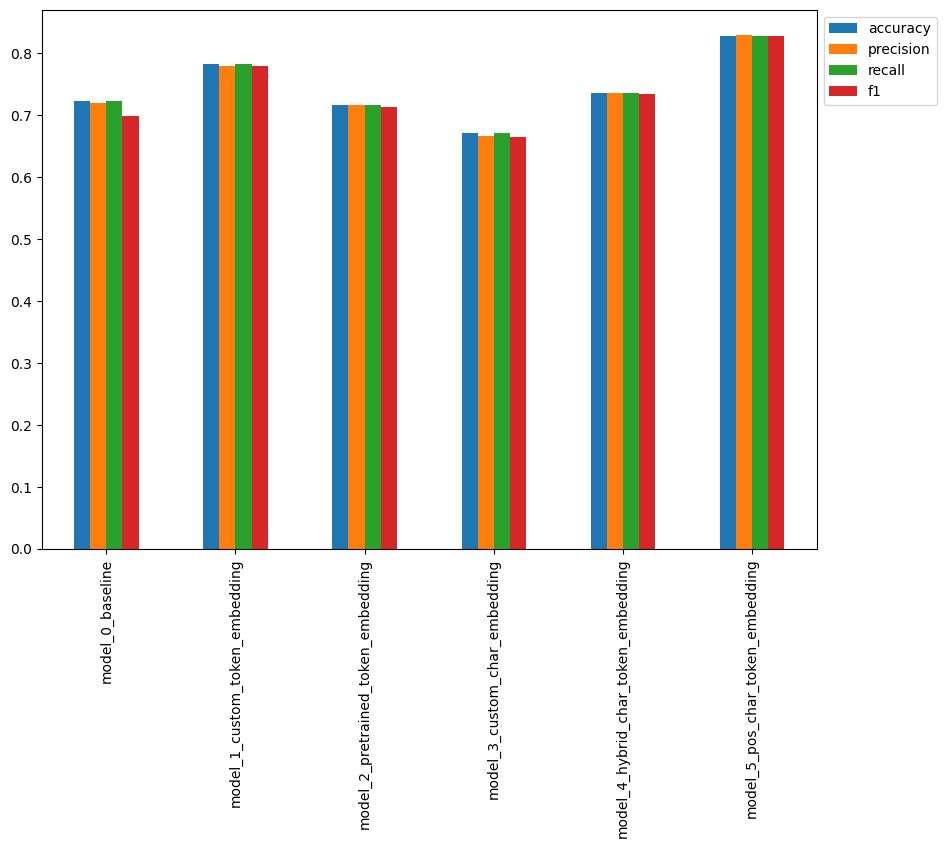

In [ ]:
import matplotlib.pyplot as plt
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

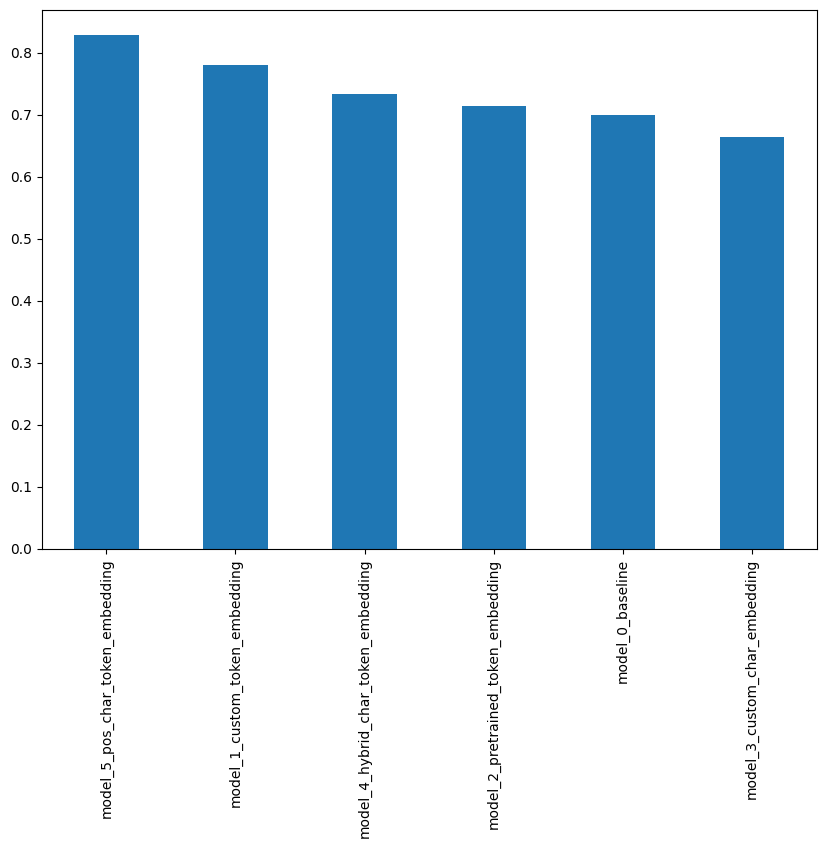

In [ ]:
all_model_results.sort_values(by='f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))